In [49]:
import sys
sys.path.append("../")
sys.path.append("../../")

import os
import random
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from predict import predict
from open_data import open_data, create_global_batch,get_df_stats,apply_norm
from dataset import RadarDataset,RadarCollate
from encoder_decoder_clean import lstm_seq2seq
from simple_model import LSTM
from train import train
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from torch.utils.data import DataLoader

In [7]:
PATH_CSV="/Users/iris/Documents/radar_deep/Radar_Traffic_Counts.csv" #"/Users/clemencevast/Documents/Courses/MachineLearning/RadarTrafficData_files/Radar_Traffic_Counts.csv" #"/Users/iris/Documents/radar_deep/Radar_Traffic_Counts.csv"
radar_name=' CAPITAL OF TEXAS HWY / LAKEWOOD DR'
DAYS_INPUT=7
WINDOW_LABEL=1
INPUT_SIZE=(DAYS_INPUT)*24*4
OUTPUT_SIZE=(WINDOW_LABEL)*24*4
TOTAL_DAYS=100
batch_size = 1

In [8]:
df1=open_data(PATH_CSV, direction="NB", radar=radar_name, year=2018)

In [9]:
batch_df=create_global_batch(df1, window_x_day=DAYS_INPUT, window_label_day=WINDOW_LABEL, gap_acquisition=1, tot_len_day=TOTAL_DAYS)
df_mean,df_std=get_df_stats(batch_df)
new_data=apply_norm(batch_df,df_mean,df_std)


Building batch 0 
 x begin 2018-01-02 label begin 2018-01-09 end period 2018-04-04 
Building batch 1 
 x begin 2018-01-03 label begin 2018-01-10 end period 2018-04-04 
Building batch 2 
 x begin 2018-01-04 label begin 2018-01-11 end period 2018-04-04 
Building batch 3 
 x begin 2018-01-05 label begin 2018-01-12 end period 2018-04-04 
We do not have all the dates for the time period in label , 96 42
Building batch 3 
 x begin 2018-01-06 label begin 2018-01-13 end period 2018-04-04 
Building batch 3 
 x begin 2018-01-07 label begin 2018-01-14 end period 2018-04-04 
Building batch 3 
 x begin 2018-01-08 label begin 2018-01-15 end period 2018-04-04 
Building batch 3 
 x begin 2018-01-09 label begin 2018-01-16 end period 2018-04-04 
Building batch 3 
 x begin 2018-01-10 label begin 2018-01-17 end period 2018-04-04 
Building batch 3 
 x begin 2018-01-11 label begin 2018-01-18 end period 2018-04-04 
Building batch 3 
 x begin 2018-01-12 label begin 2018-01-19 end period 2018-04-04 
Building b

 x begin 2018-03-29 label begin 2018-04-05 end period 2018-04-04 
Building batch 40 
 x begin 2018-03-30 label begin 2018-04-06 end period 2018-04-04 
Building batch 40 
 x begin 2018-03-31 label begin 2018-04-07 end period 2018-04-04 
Building batch 40 
 x begin 2018-04-01 label begin 2018-04-08 end period 2018-04-04 
We do not have all the dates for the time period in x , 672 654
Building batch 40 
 x begin 2018-04-02 label begin 2018-04-09 end period 2018-04-04 
Building batch 41 
 x begin 2018-04-03 label begin 2018-04-10 end period 2018-04-04 


In [ ]:
def plot_predict(dic_model,valloader,lcolor=None):
    if lcolor is None:
        lcolor=["blue","red","green","orange","purple"]
    for seq,label in valloader:
        for i,name_model in enumerate(dic_model): #dic torch_name, torchmodel
            model=dic_model[name_model]
            fig,ax=plt.subplots()
            seq_len=label.shape[1]
            pred=model.predict(seq,seq_len)
            print(pred.shape)
            print(label.shape)
            xpred=pred.reshape(seq_len)
            xlab=label.squeeze(0).detach().numpy()
            ax.plot([i for i in range(seq_len)],xpred,locor[i], label="pred_{}".format(name_model))
        ax.plot([i for i in range(seq_len)],xlab,label="label")
    ax.legend()
    plt.show()

In [10]:
fullset = RadarDataset(dataframe=batch_df,transform=None)
ptrain,pval,ptest=0.7,0.15,0.15
trainglobdataset, testdataset = train_test_split(fullset, test_size=ptest,shuffle=False)
traindataset, valdataset = train_test_split(trainglobdataset, test_size=pval/(1-ptest),shuffle=False)
collate_fn = RadarCollate()
trainloader = DataLoader(traindataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
valloader = DataLoader(valdataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
testloader = DataLoader(testdataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)


# Training LSTM encoder decoder

In [14]:
input_dim = 1   
hidden_dim = 64
layer_dim = 2
output_dim = OUTPUT_SIZE
seq_dim = 1
epochs=100
batch_size=1

In [15]:
model_seq2seq=lstm_seq2seq(1, hidden_dim)

In [17]:
iteration2,losses2,loss_val_list2=model_seq2seq.train_model(trainloader,valloader,100, output_dim, batch_size=batch_size,
                    training_prediction='teacher_forcing', teacher_forcing_ratio=0.5, learning_rate=0.01, dynamic_tf=False,name_model="encode_decod_lre-3",save=True,ite_print=2)

  2%|▏         | 2/100 [00:15<13:01,  7.97s/it, loss=0.014]

epoch 1 loss train 0.014453692754614167 loss val 0.03917878866195679


  4%|▍         | 4/100 [00:32<13:00,  8.13s/it, loss=0.016]

epoch 3 loss train 0.01639444736065343 loss val 0.03572307154536247


  6%|▌         | 6/100 [00:57<15:48, 10.09s/it, loss=0.015]

epoch 5 loss train 0.014959277657908387 loss val 0.041390448808670044


  8%|▊         | 8/100 [01:20<16:26, 10.72s/it, loss=0.014]

epoch 7 loss train 0.013831259922881145 loss val 0.04417365789413452


 10%|█         | 10/100 [01:46<17:12, 11.48s/it, loss=0.013]

epoch 9 loss train 0.013049492743448354 loss val 0.03644034266471863


 12%|█▏        | 12/100 [02:16<19:31, 13.32s/it, loss=0.013]

epoch 11 loss train 0.01267359535995638 loss val 0.034958064556121826


 14%|█▍        | 14/100 [02:46<20:37, 14.39s/it, loss=0.016]

epoch 13 loss train 0.015845501955482177 loss val 0.049212850630283356


 16%|█▌        | 16/100 [03:15<21:04, 15.05s/it, loss=0.012]

epoch 15 loss train 0.011822965956525877 loss val 0.034965965896844864


 18%|█▊        | 18/100 [03:58<25:14, 18.47s/it, loss=0.012]

epoch 17 loss train 0.011995040164038073 loss val 0.042999014258384705


 20%|██        | 20/100 [04:35<24:30, 18.38s/it, loss=0.014]

epoch 19 loss train 0.013739592221099883 loss val 0.03769605606794357


 22%|██▏       | 22/100 [05:15<24:56, 19.19s/it, loss=0.011]

epoch 21 loss train 0.011387665057554841 loss val 0.034657225012779236


 24%|██▍       | 24/100 [05:52<24:04, 19.00s/it, loss=0.011]

epoch 23 loss train 0.01139024392614374 loss val 0.045125026255846024


 26%|██▌       | 26/100 [06:28<22:18, 18.08s/it, loss=0.012]

epoch 25 loss train 0.01182637813326437 loss val 0.034197647124528885


 28%|██▊       | 28/100 [07:00<20:55, 17.44s/it, loss=0.013]

epoch 27 loss train 0.012804700862034224 loss val 0.040872640907764435


 30%|███       | 30/100 [07:30<18:53, 16.20s/it, loss=0.012]

epoch 29 loss train 0.011889058827364352 loss val 0.05006687715649605


 32%|███▏      | 32/100 [08:00<17:43, 15.64s/it, loss=0.013]

epoch 31 loss train 0.012587831333803479 loss val 0.07795557379722595


 34%|███▍      | 34/100 [08:33<17:41, 16.09s/it, loss=0.010]

epoch 33 loss train 0.010275296997861005 loss val 0.037299416959285736


 36%|███▌      | 36/100 [09:03<16:33, 15.52s/it, loss=0.014]

epoch 35 loss train 0.014415983976505231 loss val 0.045902881771326065


 38%|███▊      | 38/100 [09:41<17:48, 17.23s/it, loss=0.011]

epoch 37 loss train 0.010502609540708363 loss val 0.03395318239927292


 40%|████      | 40/100 [10:17<17:35, 17.59s/it, loss=0.012]

epoch 39 loss train 0.011807581577158999 loss val 0.03504633158445358


 42%|████▏     | 42/100 [10:39<13:48, 14.28s/it, loss=0.012]

epoch 41 loss train 0.011836052959552035 loss val 0.03759163245558739


 44%|████▍     | 44/100 [10:58<10:55, 11.71s/it, loss=0.012]

epoch 43 loss train 0.012091987271560356 loss val 0.03556160628795624


 46%|████▌     | 46/100 [11:16<09:13, 10.26s/it, loss=0.013]

epoch 45 loss train 0.013083721089060418 loss val 0.03567396104335785


 48%|████▊     | 48/100 [11:34<08:31,  9.83s/it, loss=0.010]

epoch 47 loss train 0.010289253885275684 loss val 0.03622760996222496


 50%|█████     | 50/100 [11:54<08:11,  9.84s/it, loss=0.012]

epoch 49 loss train 0.012345190185442334 loss val 0.04728035628795624


 52%|█████▏    | 52/100 [12:13<07:46,  9.71s/it, loss=0.013]

epoch 51 loss train 0.013098097195324954 loss val 0.053345441818237305


 54%|█████▍    | 54/100 [12:31<07:01,  9.16s/it, loss=0.014]

epoch 53 loss train 0.014437064070079941 loss val 0.03467699885368347


 56%|█████▌    | 56/100 [12:48<06:37,  9.02s/it, loss=0.012]

epoch 55 loss train 0.012003702810034156 loss val 0.04507254809141159


 58%|█████▊    | 58/100 [13:06<06:17,  8.99s/it, loss=0.011]

epoch 57 loss train 0.011338072370563168 loss val 0.05929133668541908


 60%|██████    | 60/100 [13:24<06:00,  9.01s/it, loss=0.012]

epoch 59 loss train 0.011671593274513725 loss val 0.05446051061153412


 62%|██████▏   | 62/100 [13:43<05:51,  9.26s/it, loss=0.013]

epoch 61 loss train 0.013262064021546394 loss val 0.04717894643545151


 64%|██████▍   | 64/100 [14:01<05:28,  9.13s/it, loss=0.010]

epoch 63 loss train 0.010459622499183752 loss val 0.037124231457710266


 66%|██████▌   | 66/100 [14:19<05:08,  9.06s/it, loss=0.013]

epoch 65 loss train 0.012882988670753548 loss val 0.034749649465084076


 68%|██████▊   | 68/100 [14:42<05:27, 10.25s/it, loss=0.012]

epoch 67 loss train 0.011950373929721536 loss val 0.037282880395650864


 70%|███████   | 70/100 [15:01<04:53,  9.77s/it, loss=0.012]

epoch 69 loss train 0.011502892535645515 loss val 0.03487769514322281


 72%|███████▏  | 72/100 [15:19<04:22,  9.39s/it, loss=0.013]

epoch 71 loss train 0.01288436263348558 loss val 0.04306621104478836


 74%|███████▍  | 74/100 [15:40<04:22, 10.09s/it, loss=0.011]

epoch 73 loss train 0.011242903245147318 loss val 0.035838477313518524


 76%|███████▌  | 76/100 [16:05<04:33, 11.40s/it, loss=0.120]

epoch 75 loss train 0.1200448068411788 loss val 0.030995022505521774


 78%|███████▊  | 78/100 [16:26<03:55, 10.71s/it, loss=0.008]

epoch 77 loss train 0.008084843895630911 loss val 0.036238208413124084


 80%|████████  | 80/100 [16:46<03:26, 10.35s/it, loss=0.009]

epoch 79 loss train 0.008844626434438396 loss val 0.018774211406707764


 82%|████████▏ | 82/100 [17:08<03:12, 10.71s/it, loss=0.008]

epoch 81 loss train 0.008396059318329208 loss val 0.029780516400933266


 84%|████████▍ | 84/100 [17:26<02:39,  9.96s/it, loss=0.009]

epoch 83 loss train 0.008518941183865536 loss val 0.021860582754015923


 86%|████████▌ | 86/100 [17:46<02:16,  9.76s/it, loss=0.008]

epoch 85 loss train 0.007594864564453019 loss val 0.025372400879859924


 88%|████████▊ | 88/100 [18:04<01:53,  9.43s/it, loss=0.007]

epoch 87 loss train 0.007469780364772305 loss val 0.024357087910175323


 90%|█████████ | 90/100 [18:23<01:33,  9.32s/it, loss=0.008]

epoch 89 loss train 0.007828479840100044 loss val 0.019396651536226273


 92%|█████████▏| 92/100 [18:39<01:09,  8.73s/it, loss=0.007]

epoch 91 loss train 0.0073608960447018035 loss val 0.01705588586628437


 94%|█████████▍| 94/100 [18:56<00:51,  8.54s/it, loss=0.008]

epoch 93 loss train 0.00756574998376891 loss val 0.017573893070220947


 96%|█████████▌| 96/100 [19:14<00:35,  8.86s/it, loss=0.009]

epoch 95 loss train 0.008797589121968485 loss val 0.025535253807902336


 98%|█████████▊| 98/100 [19:34<00:18,  9.50s/it, loss=0.008]

epoch 97 loss train 0.008043579575314652 loss val 0.023659633472561836


100%|██████████| 100/100 [19:53<00:00, 11.93s/it, loss=0.008]

epoch 99 loss train 0.007979109414009145 loss val 0.01791868731379509


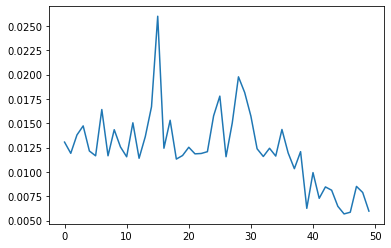

In [21]:
fig,ax=plt.subplots()
ax.plot([i for i in range(len(loss_val_list2))],loss_val_list2)

Change in the learning rate

In [24]:
model_seq2seq_lr2=lstm_seq2seq(1, hidden_dim)

In [25]:
iteration,losses,loss_val_list=model_seq2seq_lr2.train_model(trainloader,valloader,100, output_dim, batch_size=batch_size,
                    training_prediction='recursive', teacher_forcing_ratio=0.5, learning_rate=0.001, dynamic_tf=False,ite_print=2)

  2%|▏         | 2/100 [00:18<14:22,  8.80s/it, loss=0.028]

epoch 1 loss train 0.02754854451632127 loss val 0.05377160757780075


  4%|▍         | 4/100 [00:36<14:16,  8.93s/it, loss=0.016]

epoch 3 loss train 0.016080740198958665 loss val 0.03562553599476814


  6%|▌         | 6/100 [00:53<13:40,  8.73s/it, loss=0.016]

epoch 5 loss train 0.015926694322843105 loss val 0.03878350928425789


  8%|▊         | 8/100 [01:10<13:08,  8.57s/it, loss=0.016]

epoch 7 loss train 0.01634301317972131 loss val 0.03748643398284912


 10%|█         | 10/100 [01:27<12:46,  8.52s/it, loss=0.016]

epoch 9 loss train 0.015644246435840614 loss val 0.042351238429546356


 12%|█▏        | 12/100 [01:43<12:25,  8.47s/it, loss=0.016]

epoch 11 loss train 0.01578648082795553 loss val 0.03916684910655022


 14%|█▍        | 14/100 [02:01<12:16,  8.56s/it, loss=0.016]

epoch 13 loss train 0.015902638901025057 loss val 0.038557831197977066


 16%|█▌        | 16/100 [02:18<12:00,  8.57s/it, loss=0.016]

epoch 15 loss train 0.016044710006099194 loss val 0.0392664410173893


 18%|█▊        | 18/100 [02:34<11:35,  8.48s/it, loss=0.016]

epoch 17 loss train 0.016103652320452966 loss val 0.039229899644851685


 20%|██        | 20/100 [02:51<11:18,  8.48s/it, loss=0.016]

epoch 19 loss train 0.015847678994759917 loss val 0.034987229853868484


 22%|██▏       | 22/100 [03:08<10:58,  8.44s/it, loss=0.016]

epoch 21 loss train 0.015773199032992125 loss val 0.034613437950611115


 24%|██▍       | 24/100 [03:25<10:49,  8.54s/it, loss=0.016]

epoch 23 loss train 0.01600940400385298 loss val 0.035444892942905426


 26%|██▌       | 26/100 [03:42<10:24,  8.44s/it, loss=0.016]

epoch 25 loss train 0.015939662349410355 loss val 0.03647971153259277


 28%|██▊       | 28/100 [04:00<10:26,  8.70s/it, loss=0.016]

epoch 27 loss train 0.015985979232937098 loss val 0.036204174160957336


 30%|███       | 30/100 [04:16<09:59,  8.56s/it, loss=0.016]

epoch 29 loss train 0.01589479178073816 loss val 0.03474169597029686


 32%|███▏      | 32/100 [04:33<09:34,  8.45s/it, loss=0.016]

epoch 31 loss train 0.015815503400517628 loss val 0.034199923276901245


 34%|███▍      | 34/100 [04:50<09:12,  8.37s/it, loss=0.016]

epoch 33 loss train 0.01604873473115731 loss val 0.03619653359055519


 36%|███▌      | 36/100 [05:06<08:57,  8.40s/it, loss=0.016]

epoch 35 loss train 0.015908994188066572 loss val 0.03496965765953064


 38%|███▊      | 38/100 [05:23<08:46,  8.49s/it, loss=0.016]

epoch 37 loss train 0.015880183258559555 loss val 0.03595500439405441


 40%|████      | 40/100 [05:41<08:41,  8.70s/it, loss=0.016]

epoch 39 loss train 0.015788378776051104 loss val 0.036636073142290115


 42%|████▏     | 42/100 [05:59<08:35,  8.89s/it, loss=0.016]

epoch 41 loss train 0.0160519238706911 loss val 0.035278525203466415


 44%|████▍     | 44/100 [06:16<08:06,  8.69s/it, loss=0.016]

epoch 43 loss train 0.015987937687896192 loss val 0.035064589232206345


 44%|████▍     | 44/100 [06:24<08:09,  8.75s/it, loss=0.016]


KeyboardInterrupt: 

In [71]:
hidden_dim = 256

In [73]:
model_seq2seq_lr3=lstm_seq2seq(1, hidden_dim)

In [ ]:
iteration3,losses3,loss_val_list3=model_seq2seq_lr3.train_model(trainloader,valloader,500, output_dim, batch_size=batch_size,
                    training_prediction='teacher_forcing', teacher_forcing_ratio=0.3, learning_rate=0.01, dynamic_tf=True,ite_print=2)

  0%|          | 1/500 [00:12<1:46:22, 12.79s/it, loss=2.037]/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type lstm_seq2seq. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type lstm_encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrie

epoch 1 loss train 0.018104888091329485 loss val 0.035792864859104156


  1%|          | 4/500 [00:49<1:43:16, 12.49s/it, loss=0.015]

epoch 3 loss train 0.015385513514047489 loss val 0.039179909974336624


  1%|          | 6/500 [01:14<1:42:43, 12.48s/it, loss=0.016]

epoch 5 loss train 0.01557202845287975 loss val 0.03434468060731888


  2%|▏         | 8/500 [01:39<1:43:33, 12.63s/it, loss=0.016]

epoch 7 loss train 0.015508995129493997 loss val 0.03517206013202667


  2%|▏         | 10/500 [02:04<1:42:25, 12.54s/it, loss=0.014]

epoch 9 loss train 0.01439716421009507 loss val 0.026805147528648376


  2%|▏         | 12/500 [02:29<1:41:13, 12.44s/it, loss=0.011]

epoch 11 loss train 0.011285268177744001 loss val 0.020425869151949883


  3%|▎         | 14/500 [02:54<1:40:43, 12.43s/it, loss=0.009]

epoch 13 loss train 0.008677950689161662 loss val 0.022681236267089844


  3%|▎         | 16/500 [03:18<1:39:46, 12.37s/it, loss=0.009]

epoch 15 loss train 0.009073941178940004 loss val 0.025476615875959396


  4%|▎         | 18/500 [03:43<1:39:24, 12.37s/it, loss=0.009]

epoch 17 loss train 0.008524005643266719 loss val 0.024154499173164368


  4%|▍         | 20/500 [04:08<1:39:34, 12.45s/it, loss=0.008]

epoch 19 loss train 0.008175858463800978 loss val 0.02097489684820175


  4%|▍         | 22/500 [04:33<1:38:50, 12.41s/it, loss=0.009]

epoch 21 loss train 0.008546005112293642 loss val 0.022017110139131546


  5%|▍         | 24/500 [05:03<1:51:25, 14.04s/it, loss=0.008]

epoch 23 loss train 0.008249416576290969 loss val 0.017061663791537285


  5%|▌         | 26/500 [05:35<1:57:17, 14.85s/it, loss=0.009]

epoch 25 loss train 0.00917271612706827 loss val 0.024829529225826263


  6%|▌         | 28/500 [06:05<1:56:49, 14.85s/it, loss=0.008]

epoch 27 loss train 0.008449041924905032 loss val 0.021924927830696106


  6%|▌         | 30/500 [06:31<1:50:20, 14.09s/it, loss=0.009]

epoch 29 loss train 0.008644061570521444 loss val 0.021125856786966324


  6%|▋         | 32/500 [06:59<1:49:27, 14.03s/it, loss=0.009]

epoch 31 loss train 0.0085451232152991 loss val 0.0221887044608593


  7%|▋         | 34/500 [07:26<1:46:41, 13.74s/it, loss=0.009]

epoch 33 loss train 0.008855547435814515 loss val 0.019765688106417656


  7%|▋         | 36/500 [07:53<1:45:56, 13.70s/it, loss=0.009]

epoch 35 loss train 0.00886068837280618 loss val 0.021137554198503494


  8%|▊         | 38/500 [08:19<1:44:03, 13.51s/it, loss=0.008]

epoch 37 loss train 0.008120682105072774 loss val 0.018623171374201775


  8%|▊         | 40/500 [08:46<1:43:16, 13.47s/it, loss=0.008]

epoch 39 loss train 0.00824317395745311 loss val 0.018107758834958076


  8%|▊         | 42/500 [09:13<1:43:24, 13.55s/it, loss=0.008]

epoch 41 loss train 0.008408451627474278 loss val 0.024184484034776688


  9%|▉         | 44/500 [09:40<1:42:34, 13.50s/it, loss=0.008]

epoch 43 loss train 0.00829519602120854 loss val 0.021335164085030556


  9%|▉         | 46/500 [10:07<1:41:56, 13.47s/it, loss=0.008]

epoch 45 loss train 0.008241237512265798 loss val 0.020326638594269753


 10%|▉         | 48/500 [10:34<1:41:14, 13.44s/it, loss=0.008]

epoch 47 loss train 0.007676540313696023 loss val 0.020032081753015518


 10%|█         | 50/500 [11:00<1:40:04, 13.34s/it, loss=0.008]

epoch 49 loss train 0.007962576855788939 loss val 0.02088984288275242


 10%|█         | 52/500 [11:27<1:39:21, 13.31s/it, loss=0.008]

epoch 51 loss train 0.008213969922508113 loss val 0.02511286735534668


 11%|█         | 54/500 [11:54<1:39:28, 13.38s/it, loss=0.008]

epoch 53 loss train 0.007840580379706807 loss val 0.01733367145061493


 11%|█         | 56/500 [12:20<1:38:08, 13.26s/it, loss=0.008]

epoch 55 loss train 0.007829727030184586 loss val 0.024917950853705406


 12%|█▏        | 58/500 [12:44<1:34:00, 12.76s/it, loss=0.008]

epoch 57 loss train 0.008148472334141843 loss val 0.02145501598715782


 12%|█▏        | 60/500 [13:09<1:32:00, 12.55s/it, loss=0.008]

epoch 59 loss train 0.0077662827461608686 loss val 0.021238889545202255


 12%|█▏        | 62/500 [13:34<1:30:46, 12.43s/it, loss=0.008]

epoch 61 loss train 0.007663180607778486 loss val 0.019880782812833786


 13%|█▎        | 64/500 [14:03<1:40:16, 13.80s/it, loss=0.007]

epoch 63 loss train 0.007429614081047475 loss val 0.02261243388056755


 13%|█▎        | 66/500 [14:32<1:41:26, 14.02s/it, loss=0.007]

epoch 65 loss train 0.007330981956329197 loss val 0.0201110877096653


 14%|█▎        | 68/500 [14:58<1:38:03, 13.62s/it, loss=0.008]

epoch 67 loss train 0.00820029694295954 loss val 0.020495928823947906


 14%|█▍        | 70/500 [15:23<1:34:15, 13.15s/it, loss=0.008]

epoch 69 loss train 0.007654949047719128 loss val 0.02260974794626236


 14%|█▍        | 72/500 [15:48<1:30:53, 12.74s/it, loss=0.008]

epoch 71 loss train 0.008138786033669021 loss val 0.026877766475081444


 15%|█▍        | 74/500 [16:13<1:29:14, 12.57s/it, loss=0.008]

epoch 73 loss train 0.008006080744962674 loss val 0.018731482326984406


 15%|█▌        | 76/500 [16:37<1:28:04, 12.46s/it, loss=0.008]

epoch 75 loss train 0.008031629222386982 loss val 0.020488375797867775


 16%|█▌        | 78/500 [17:02<1:27:52, 12.49s/it, loss=0.008]

epoch 77 loss train 0.008430381487414706 loss val 0.019053364172577858


 16%|█▌        | 80/500 [17:27<1:28:00, 12.57s/it, loss=0.008]

epoch 79 loss train 0.007845558924600482 loss val 0.019681740552186966


In [65]:
def plot_predict(dic_model,valloader,seq_len,lcolor=None):
    if lcolor is None:
        lcolor=["blue","red","green","orange","purple"]
    for seq,label in valloader:
        fig, ax = plt.subplots()
        for i,name_model in enumerate(dic_model): #dic torch_name, torchmodel
            model=dic_model[name_model]
            if name_model=="lstm":
                model.eval()
                xpred=model(seq).detach().numpy()
            else:
                pred=model.predict(seq,seq_len)
                print(pred.shape)
                print(label.shape)
                xpred=pred.squeeze(1).squeeze(1).detach().numpy()
                print(xpred.shape)
            ax.plot([i for i in range(seq_len)],xpred,lcolor[i], label="pred_{}".format(name_model))
        xlab = label.squeeze(0).detach().numpy()
        ax.plot([i for i in range(seq_len)],xlab,"black",label="label")
        ax.legend()
        plt.show()

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


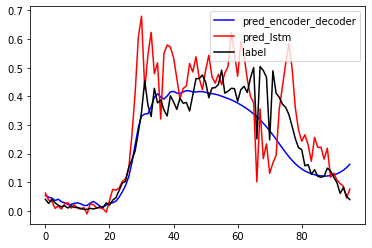

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


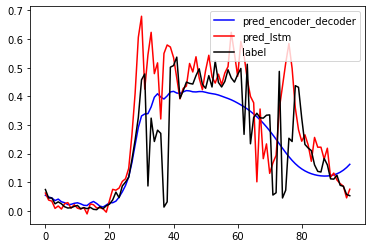

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


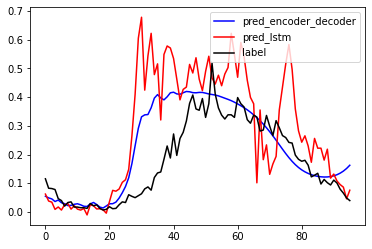

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


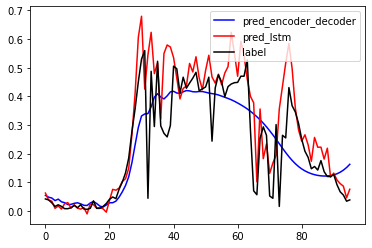

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


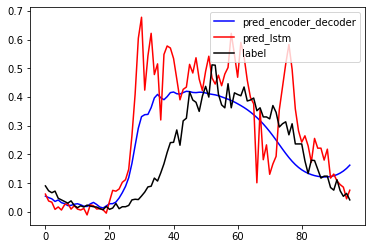

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


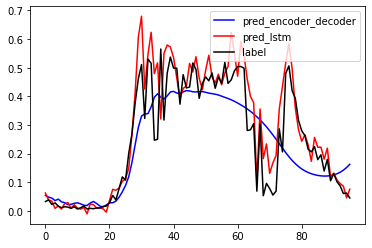

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


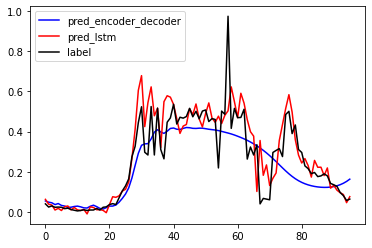

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


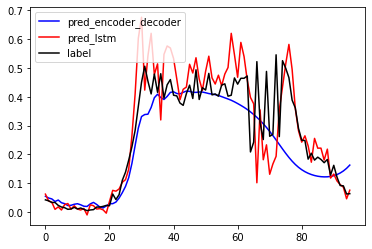

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


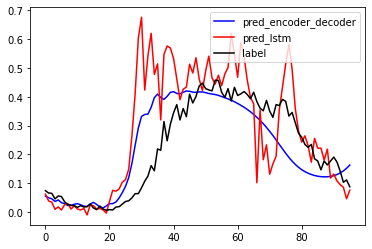

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


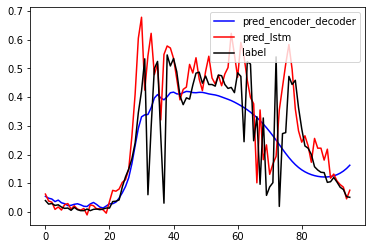

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


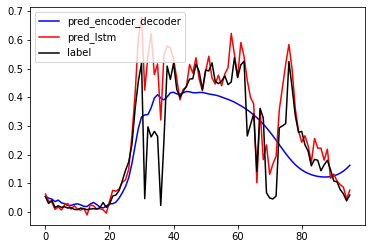

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


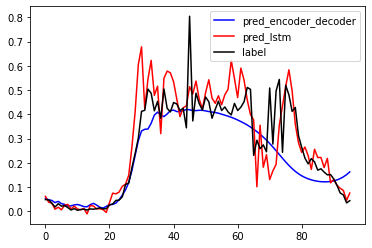

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


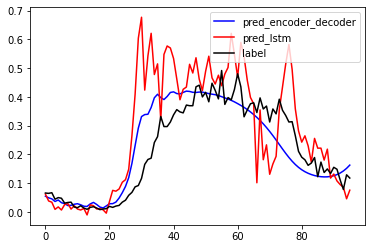

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


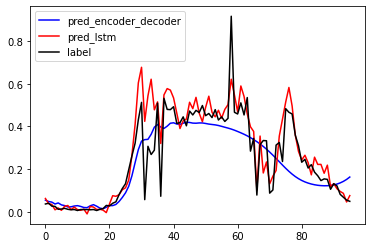

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


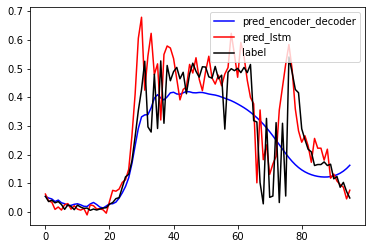

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


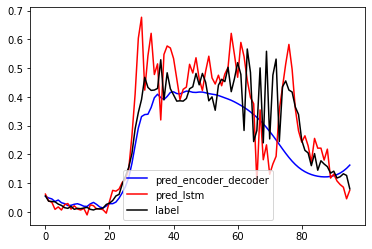

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


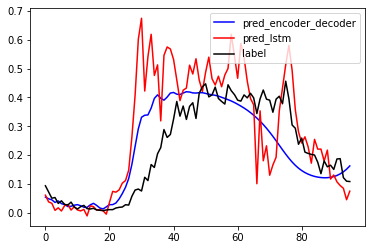

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


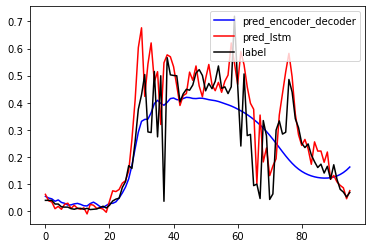

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


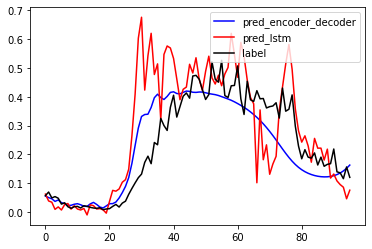

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


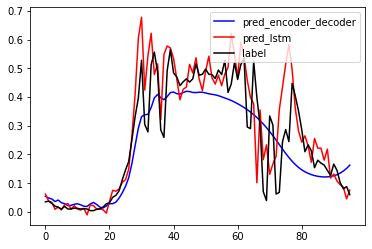

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


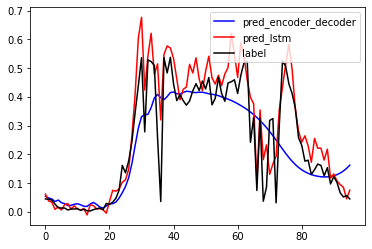

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


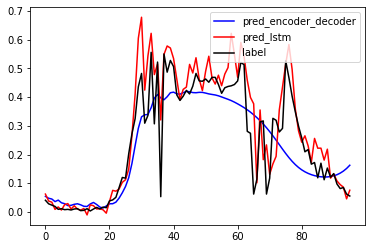

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


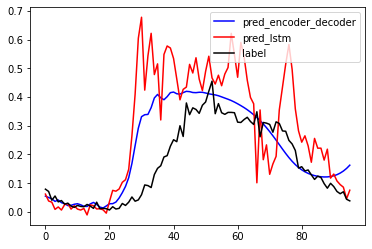

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


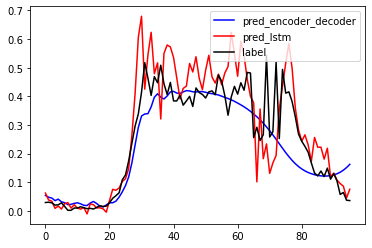

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


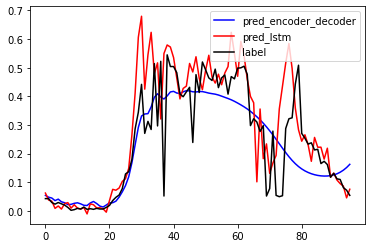

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


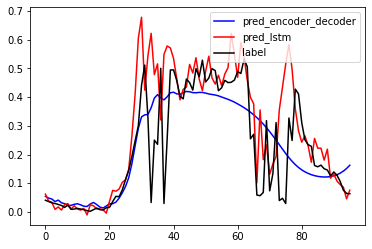

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


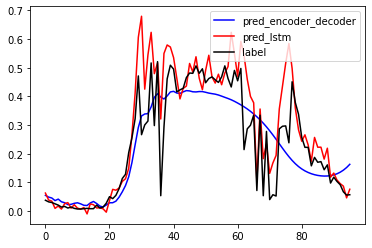

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


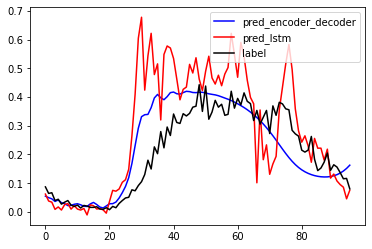

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


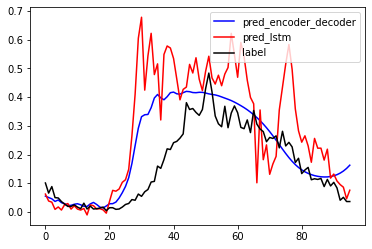

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


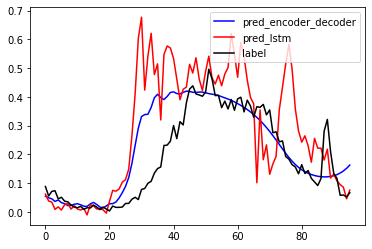

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


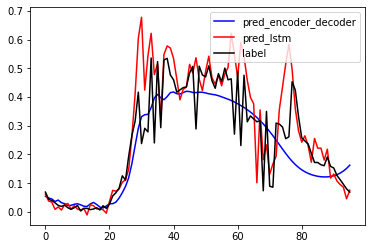

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


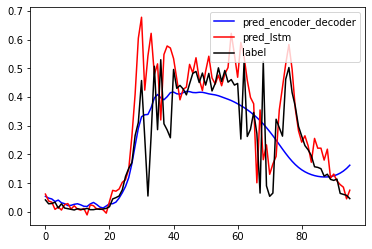

In [68]:
plot_predict({"encoder_decoder":model_seq2seq_lr3,"lstm":model},trainloader,96)

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


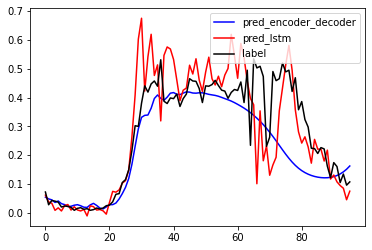

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


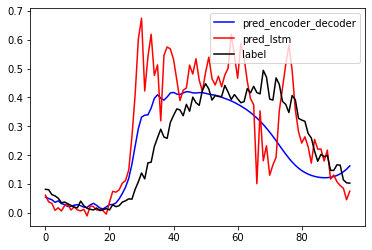

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


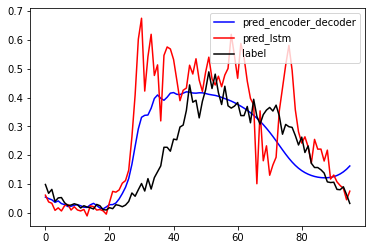

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


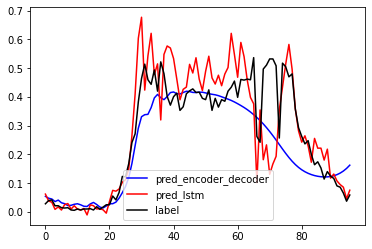

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


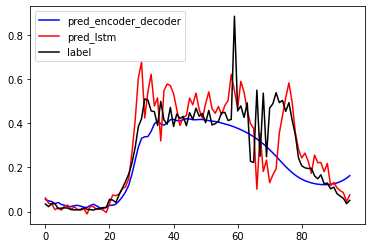

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


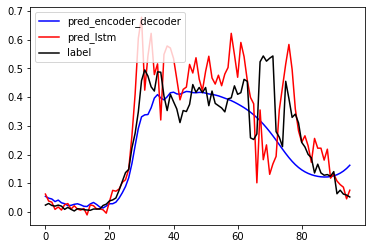

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


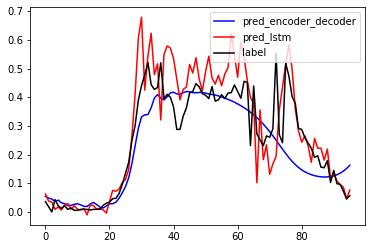

In [70]:
plot_predict({"encoder_decoder":model_seq2seq_lr3,"lstm":model},testloader,96)

In [52]:
input_dim = INPUT_SIZE   
hidden_dim = 256
layer_dim = 2
output_dim = OUTPUT_SIZE
seq_dim = 1

lr = 0.05
n_epochs = 300
iterations_per_epoch = len(trainloader)
name_model = "simple_model_smalldataset_lr5e-2"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
model=LSTM(input_size=input_dim,hidden_size=hidden_dim,output_size=output_dim)


In [53]:
iteration_sm,loss_train_list_sm,loss_val_list_sm=train(model, trainloader, valloader, lr=lr, n_epochs=n_epochs, name_model=name_model, device=device, ite_print=5,save=True)

/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 96])) that is different to the input size (torch.Size([96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1 loss train 0.008406988345086575 loss val 0.00733605632558465


/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch 6 loss train 0.003726701717823744 loss val 0.0063735670410096645
epoch 11 loss train 0.0045509724877774715 loss val 0.006397200282663107
epoch 16 loss train 0.004224316217005253 loss val 0.006593207363039255
epoch 21 loss train 0.009880243800580502 loss val 0.007390396669507027
epoch 26 loss train 0.009210361167788506 loss val 0.007585143204778433
epoch 31 loss train 0.016036540269851685 loss val 0.013288366608321667
epoch 36 loss train 0.005148252472281456 loss val 0.010537125170230865
epoch 41 loss train 0.012951220385730267 loss val 0.013328886590898037
epoch 46 loss train 0.006074537057429552 loss val 0.01793675869703293
epoch 51 loss train 0.013069498352706432 loss val 0.008316755294799805
epoch 56 loss train 0.011490204371511936 loss val 0.012149211950600147
epoch 61 loss train 0.004649559035897255 loss val 0.009737054817378521
epoch 66 loss train 0.008686024695634842 loss val 0.010134434327483177
epoch 71 loss train 0.008943570777773857 loss val 0.013642181642353535
epoch 